Data from Airbnb listings in Melbourne - Australia.

In [1]:
#!pip install -q matplotlib
#!pip install -q scikit-learn

In [2]:
# Imports

import csv
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## Analyzing raw data

In [3]:
# Functions

def get_statistics(x=list):
    """
    This function creates an f string with statistics for a given variable.
    """
    from numpy import mean, median
    from statistics import stdev, quantiles, variance, mean

    return f'''Statistics Report
The variable contains {len(x)} elements.
Values = [{min(x)}, {max(x)}]
Amplitude = {max(x) - min(x)}
Median = {median(x):.2f}
Mean ± s = {mean(x):.2f} ± {stdev(x):.2f}
Variance = {variance(x):.2f}
------------------------------
Quantiles:
Q1 = {quantiles(x)[0]:.2f}
Q2 = {quantiles(x)[1]:.2f}
Q3 = {quantiles(x)[2]:.2f}
------------------------------
IQR = {quantiles(x)[2] - quantiles(x)[0]:.2f}
Lower bound = {quantiles(x)[0] - (1.5 * (quantiles(x)[2] - quantiles(x)[0])):.2f}
Upper bound = {quantiles(x)[2] + (1.5 * (quantiles(x)[2] - quantiles(x)[0])):.2f}
'''


def get_lowerbound(x=list):
    """
    This function gets the lower bound of a given variable using the IQR method.
    """
    from statistics import quantiles
    lower_bound = quantiles(x)[0] - (1.5 * (quantiles(x)[2] - quantiles(x)[0]))
    return lower_bound


def get_upperbound(x=list):
    """
    This function gets the upper bound of a given variable using the IQR method.
    """
    from statistics import quantiles
    upper_bound = quantiles(x)[2] + (1.5 * (quantiles(x)[2] - quantiles(x)[0]))
    return upper_bound

In [4]:
# Getting data from Melbourne Airbnb listings;
# Checking field names and creating "raw_price" variable for the "Price" column

FILE_NAME = '/content/listings.csv'
with open(FILE_NAME, newline='', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    el, fnames, raw_price = 0, reader.fieldnames, []
    for row in reader:
        el += 1
        raw_price.append(float(row.get('price')))
    print(f'Headers: {fnames}')

Headers: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'license']


In [5]:
# Creating a statistical report for raw_price to understand the data and saving it to a .txt file

# with open('Statistics for Raw Data Price.txt', mode='w', encoding='utf-8') as file:
#    report = file.write(get_statistics(raw_price))

In [6]:
# Getting Statistics for raw_price

print(get_statistics(raw_price))

Statistics Report
The variable contains 20768 elements.
Values = [0.0, 145160.0]
Amplitude = 145160.0
Median = 160.00
Mean ± s = 289.79 ± 2446.53
Variance = 5985486.98
------------------------------
Quantiles:
Q1 = 99.00
Q2 = 160.00
Q3 = 250.00
------------------------------
IQR = 151.00
Lower bound = -127.50
Upper bound = 476.50



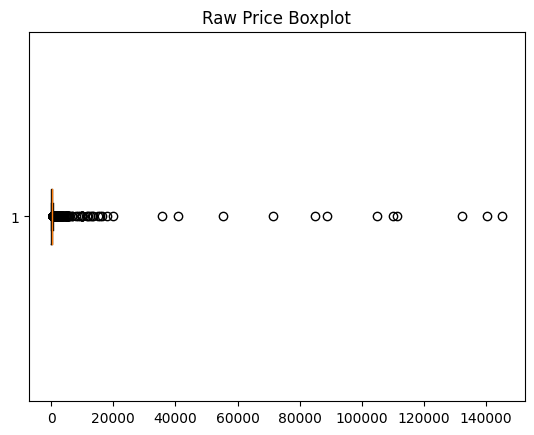

In [7]:
# Visualizing raw_price bloxplot to check for outliers

plt.figure('Raw_Price_Boxplot.png')
plt.boxplot(raw_price, vert=False)
plt.title('Raw Price Boxplot')
plt.show()

As seen on the boxplot, the "raw price" variable has outliers, so I'll filter the dataset based on "raw_price" and create a new .csv file, filtering the data using the IQR method.

I'll also check how many elements there are after filtering the dataset and create a new variable to get the filtered data price, called "filtered_price".

In [8]:
# Writing the new .csv file with filtered data

with open(FILE_NAME, newline='', encoding='utf-8') as csvfile:
    with open('filtered_data.csv', mode='w', encoding='utf-8') as new_csvfile:
        reader = csv.DictReader(csvfile)
        writer = csv.DictWriter(new_csvfile, fieldnames=fnames)

        el_2, lower, upper, filtered_price = 0, get_lowerbound(raw_price), get_upperbound(raw_price), []
        writer.writeheader()
        for row in reader:
            if float(row.get('price')) > upper or float(row.get('price')) < lower:
                pass
            else:
                el_2 += 1
                writer.writerow(row)
                filtered_price.append(float(row.get('price')))

In [9]:
# Getting statistics for filtered_price and saving it into a new .txt file

# with open('Statistics for Filtered Data Price.txt', mode='w', encoding='utf-8') as file:
#    report = file.write(get_statistics(filtered_price))

In [10]:
# Getting Statistics for filtered_price

print(get_statistics(filtered_price))

Statistics Report
The variable contains 19168 elements.
Values = [0.0, 476.0]
Amplitude = 476.0
Median = 150.00
Mean ± s = 168.28 ± 98.08
Variance = 9619.44
------------------------------
Quantiles:
Q1 = 91.00
Q2 = 150.00
Q3 = 220.00
------------------------------
IQR = 129.00
Lower bound = -102.50
Upper bound = 413.50



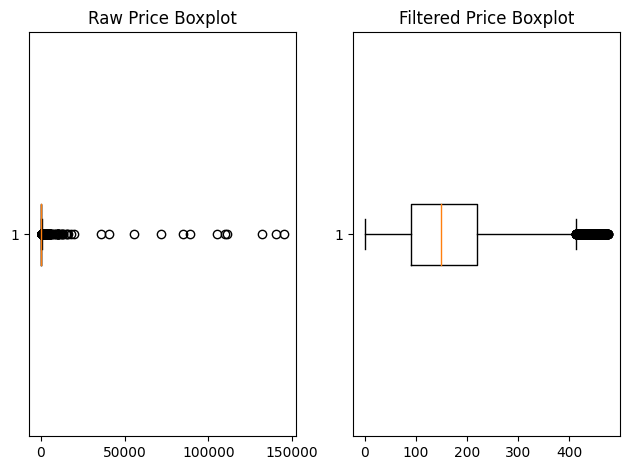

In [11]:
# Visualizing the price variable comparison before and after filtering

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[0].boxplot(raw_price, vert=False)
axs[0].set_title('Raw Price Boxplot')
axs[1].boxplot(filtered_price, vert=False)
axs[1].set_title('Filtered Price Boxplot')
plt.tight_layout()
plt.show()

Comparing boxplots and statistics for the same variable (price) before and after filtering the dataset, it's possible to see that cleaning the data with the IQR method resulted in a more cohesive data.

Now, I'll start checking for possibilities  to gain more insights from this dataset through machine learning models.


## Linear Regression

First, I will study the possibility of using Linear Regression to gain insights about the correlation between the price variable and the other numerical variables, one at a time.

In [12]:
# Getting data from the new .csv file created in "raw_data.py"

FILE_NAME = '/content/filtered_data.csv'
with open(FILE_NAME, newline='', mode='r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)

    # Creating a list for each numeric variable, filling gaps with 0

    fprice, fmnights, fnrev, frpm, fchlc, fava = [], [], [], [], [], []
    for row in reader:
        try:
            fprice.append(float(row.get('price')))
        except Exception:
            fprice.append(0)
        try:
            fmnights.append(int(row.get('minimum_nights')))
        except Exception:
            fmnights.append(0)
        try:
            fnrev.append(int(row.get('number_of_reviews')))
        except Exception:
            fnrev.append(0)
        try:
            frpm.append(float(row.get('reviews_per_month')))
        except Exception:
            frpm.append(0)
        try:
            fchlc.append(int(row.get('calculated_host_listings_count')))
        except Exception:
            fchlc.append(0)
        try:
            fava.append(int(row.get('availability_365')))
        except Exception:
            fava.append(0)

In [13]:
# Transforming "neighborhood" field into a scale

FILE_NAME = '/content/filtered_data.csv'
with open(FILE_NAME, newline='', mode='r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    neigh = []
    for row in reader:
      try:
        neigh.append(row.get('neighbourhood'))
      except Exception:
        neigh.append('Null')

    unique_neigh = set(neigh)
    print(unique_neigh)
    print(len(unique_neigh))

    unique_neigh_list, dict_neigh = list(unique_neigh), dict()
    for i in range(len(unique_neigh_list)):
      dict_neigh.update({f'{unique_neigh_list[i]}': i})
    print(dict_neigh)


{'Hobsons Bay', 'Whitehorse', 'Maroondah', 'Yarra', 'Darebin', 'Cardinia', 'Hume', 'Kingston', 'Manningham', 'Glen Eira', 'Nillumbik', 'Knox', 'Greater Dandenong', 'Moreland', 'Brimbank', 'Casey', 'Banyule', 'Melbourne', 'Frankston', 'Moonee Valley', 'Bayside', 'Melton', 'Port Phillip', 'Monash', 'Stonnington', 'Whittlesea', 'Boroondara', 'Wyndham', 'Yarra Ranges', 'Maribyrnong'}
30
{'Hobsons Bay': 0, 'Whitehorse': 1, 'Maroondah': 2, 'Yarra': 3, 'Darebin': 4, 'Cardinia': 5, 'Hume': 6, 'Kingston': 7, 'Manningham': 8, 'Glen Eira': 9, 'Nillumbik': 10, 'Knox': 11, 'Greater Dandenong': 12, 'Moreland': 13, 'Brimbank': 14, 'Casey': 15, 'Banyule': 16, 'Melbourne': 17, 'Frankston': 18, 'Moonee Valley': 19, 'Bayside': 20, 'Melton': 21, 'Port Phillip': 22, 'Monash': 23, 'Stonnington': 24, 'Whittlesea': 25, 'Boroondara': 26, 'Wyndham': 27, 'Yarra Ranges': 28, 'Maribyrnong': 29}


In [14]:
# Transforming "room type" field into a scale

FILE_NAME = '/content/filtered_data.csv'
with open(FILE_NAME, newline='', mode='r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    roomtype = []
    for row in reader:
      try:
        roomtype.append(row.get('room_type'))
      except Exception:
        roomtype.append('Null')

    unique_roomtype = set(roomtype)
    print(unique_roomtype)
    print(len(unique_roomtype))

    unique_roomtype_list, dict_roomtype = list(unique_roomtype), dict()
    for i in range(len(unique_roomtype_list)):
      dict_roomtype.update({f'{unique_roomtype_list[i]}': i})
    print(dict_roomtype)

{'Private room', 'Hotel room', 'Shared room', 'Entire home/apt'}
4
{'Private room': 0, 'Hotel room': 1, 'Shared room': 2, 'Entire home/apt': 3}


In [15]:
# Transforming neighborhood field into a scalar field

FILE_NAME = '/content/filtered_data.csv'
with open(FILE_NAME, newline='', mode='r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    fneigh = []
    for row in reader:
      for k, v in dict_neigh.items():
        if row.get('neighbourhood') == k:
          row['neighbourhood'] = v
          fneigh.append(row.get('neighbourhood'))

In [16]:
# Transforming room type field into a scalar field

FILE_NAME = '/content/filtered_data.csv'
with open(FILE_NAME, newline='', mode='r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    froomtype = []
    for row in reader:
      for k, v in dict_roomtype.items():
        if row.get('room_type') == k:
          row['room_type'] = v
          froomtype.append(row.get('room_type'))

In [17]:
# Creating the x variable with price and a list for the other variable's lists

x, LISTS = fprice, [fmnights, fnrev, frpm, fchlc, fava, fneigh, froomtype]

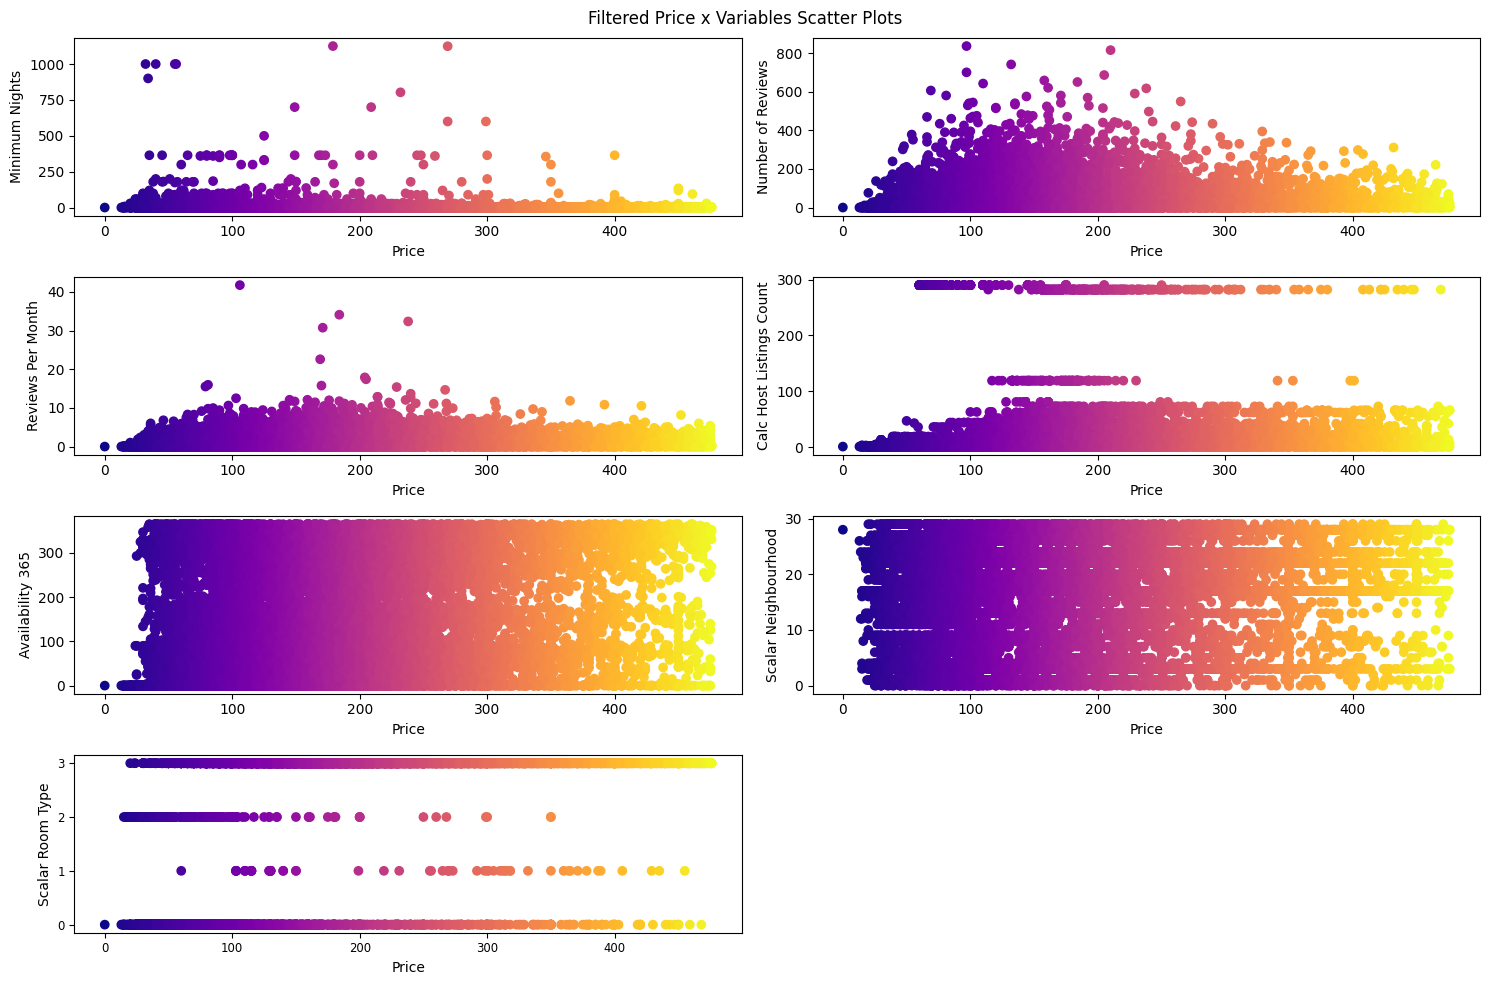

In [18]:
# Visualizing a scatter plot for each variable x price

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 10))
fig.suptitle('Filtered Price x Variables Scatter Plots')

axs[0, 0].scatter(x=x, y=fmnights, c=x, cmap='plasma', marker='o')
axs[0, 0].set_xlabel('Price')
axs[0, 0].set_ylabel('Minimum Nights')

axs[0, 1].scatter(x=x, y=fnrev, c=x, cmap='plasma')
axs[0, 1].set_xlabel('Price')
axs[0, 1].set_ylabel('Number of Reviews')

axs[1, 0].scatter(x=x, y=frpm, c=x, cmap='plasma')
axs[1, 0].set_xlabel('Price')
axs[1, 0].set_ylabel('Reviews Per Month')

axs[1, 1].scatter(x=x, y=fchlc, c=x, cmap='plasma')
axs[1, 1].set_xlabel('Price')
axs[1, 1].set_ylabel('Calc Host Listings Count')
plt.xticks(fontsize='small')
plt.yticks(fontsize='small')

axs[2, 0].scatter(x=x, y=fava, c=x, cmap='plasma')
axs[2, 0].set_xlabel('Price')
axs[2, 0].set_ylabel('Availability 365')

axs[2, 1].scatter(x=x, y=fneigh, c=x, cmap='plasma')
axs[2, 1].set_xlabel('Price')
axs[2, 1].set_ylabel('Scalar Neighbourhood')

axs[3, 0].scatter(x=x, y=froomtype, c=x, cmap='plasma')
axs[3, 0].set_xlabel('Price')
axs[3, 0].set_ylabel('Scalar Room Type')

axs[3, 1].remove()

plt.xticks(fontsize='small')
plt.yticks(fontsize='small')
plt.tight_layout()
plt.show()

In [19]:
# Defining the Model

model = LinearRegression()

In [20]:
# Defining X as Price and Y as Minimum Nights

X = np.array(fprice).reshape(-1, 1)
Y = np.array(fmnights).reshape(-1, 1)

# Splitting X and Y for train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.65)

# Fitting X and Y into the model
model.fit(X_train, Y_train)

# Creating the Equation
Y_pred = model.coef_ * X_test + model.intercept_
Y_pred_2 = model.predict(X_test)

# Assessing the model and getting the R² metric
valor = r2_score(Y_test, Y_pred_2)
if 0.8 <= valor <= 1:
    print(f'Good R² for Price x Minimum Nights = {valor:.2f}')
elif valor < 0.8:
    print(f'Bad R² for Price x Minimum Nights = {valor:.2f}')

Bad R² for Price x Minimum Nights = 0.00


In [21]:
# Defining X as Price and Y as Number of Reviews
X = np.array(fprice).reshape(-1, 1)
Y = np.array(fnrev).reshape(-1, 1)

# Splitting X and Y for train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.65)

# Fitting X and Y into the model
model.fit(X_train, Y_train)

# Creating the Equation
Y_pred = model.coef_ * X_test + model.intercept_
Y_pred_2 = model.predict(X_test)

# Assessing the model and getting the R² metric
valor = r2_score(Y_test, Y_pred_2)
if 0.8 <= valor <= 1:
    print(f'Good R² for Price x Number of Reviews = {valor:.2f}')
elif valor < 0.8:
    print(f'Bad R² for Price x Number of Reviews = {valor:.2f}')

Bad R² for Price x Number of Reviews = 0.00


In [22]:
# Defining X as Price and Y as Reviews Per Month
X = np.array(fprice).reshape(-1, 1)
Y = np.array(frpm).reshape(-1, 1)

# Splitting X and Y for train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.65)

# Fitting X and Y into the model
model.fit(X_train, Y_train)

# Creating the Equation
Y_pred = model.coef_ * X_test + model.intercept_
Y_pred_2 = model.predict(X_test)

# Assessing the model and getting the R² metric
valor = r2_score(Y_test, Y_pred_2)
if 0.8 <= valor <= 1:
    print(f'Good R² for Price x Reviews Per Month = {valor:.2f}')
elif valor < 0.8:
    print(f'Bad R² for Price x Reviews Per Month = {valor:.2f}')


Bad R² for Price x Reviews Per Month = 0.01


In [23]:
# Defining X as Price and Y as Calc Host Listings Count
X = np.array(fprice).reshape(-1, 1)
Y = np.array(fchlc).reshape(-1, 1)

# Splitting X and Y for train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.65)

# Fitting X and Y into the model
model.fit(X_train, Y_train)

# Creating the Equation
Y_pred = model.coef_ * X_test + model.intercept_
Y_pred_2 = model.predict(X_test)

# Assessing the model and getting the R² metric
valor = r2_score(Y_test, Y_pred_2)
if 0.8 <= valor <= 1:
    print(f'Good R² for Price x Calc Host Listings Count = {valor:.2f}')
elif valor < 0.8:
    print(f'Bad R² for Price x Calc Host Listings Count = {valor:.2f}')

Bad R² for Price x Calc Host Listings Count = -0.00


In [24]:
# Defining X as Price and Y as Availability 365
X = np.array(fprice).reshape(-1, 1)
Y = np.array(fava).reshape(-1, 1)

# Splitting X and Y for train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.65)

# Fitting X and Y into the model
model.fit(X_train, Y_train)

# Creating the Equation
Y_pred = model.coef_ * X_test + model.intercept_
Y_pred_2 = model.predict(X_test)

# Assessing the model and getting the R² metric
valor = r2_score(Y_test, Y_pred_2)
if 0.8 <= valor <= 1:
    print(f'Good R² for Price x Availability 365 = {valor:.2f}')
elif valor < 0.8:
    print(f'Bad R² for Price x Availability 365 = {valor:.2f}')

Bad R² for Price x Availability 365 = 0.09


In [25]:
# Defining X as Price and Y as Neighbourhood
X = np.array(fprice).reshape(-1, 1)
Y = np.array(fneigh).reshape(-1, 1)

# Splitting X and Y for train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.65)

# Fitting X and Y into the model
model.fit(X_train, Y_train)

# Creating the Equation
Y_pred = model.coef_ * X_test + model.intercept_
Y_pred_2 = model.predict(X_test)

# Assessing the model and getting the R² metric
valor = r2_score(Y_test, Y_pred_2)
if 0.8 <= valor <= 1:
    print(f'Good R² for Price x Neighbourhood = {valor:.2f}')
elif valor < 0.8:
    print(f'Bad R² for Price x Neighbourhood = {valor:.2f}')

Bad R² for Price x Neighbourhood = 0.01


In [26]:
# Defining X as Price and Y as Room Type
X = np.array(fprice).reshape(-1, 1)
Y = np.array(froomtype).reshape(-1, 1)

# Splitting X and Y for train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.65)

# Fitting X and Y into the model
model.fit(X_train, Y_train)

# Creating the Equation
Y_pred = model.coef_ * X_test + model.intercept_
Y_pred_2 = model.predict(X_test)

# Assessing the model and getting the R² metric
valor = r2_score(Y_test, Y_pred_2)
if 0.8 <= valor <= 1:
    print(f'Good R² for Price x Neighbourhood = {valor:.2f}')
elif valor < 0.8:
    print(f'Bad R² for Price x Neighbourhood = {valor:.2f}')

Bad R² for Price x Neighbourhood = 0.25


### Conclusion

As seen above, none of the single variables have a R² score higher than 0.95, which would be the minimum acceptable score to define a Linear Regression between price and another single variable.

This also goes along with the scatter plots generated before, that show no sign of a linear correlation between the price variable and any of the other variables alone.

## Decision Tree

Now I will test if it is possible to create a Decision Tree using the data from "price", "minimum nights", "number of reviews", scaled "neighbourhood" and scaled "room type", based on the occupancy rate, calculated with the "availability_365" field.

The average occupancy rate used in this project is 75%.

In [27]:
# Getting data from "filtered_data" and creating an array

FILE_NAME = '/content/filtered_data.csv'
with open(FILE_NAME, mode='r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    fnames, lines, skeys = reader.fieldnames, [], ['price', 'minimum_nights', 'number_of_reviews', 'availability_365']
    for row in reader:
        if row:
            lines.append([row[chave] for chave in skeys])

    data = np.array(lines)
    print(f'There are {len(data)} elements') # Checking for elements
    print(f' Shape of data (rows, columns) = {data.shape}') # Checking for rows and columns


There are 19168 elements
 Shape of data (rows, columns) = (19168, 4)


In [28]:
# Transforming "neighbourhood" and "room type" variables from categorical to numeric

FILE_NAME = '/content/filtered_data.csv'
with open(FILE_NAME, mode='r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    fnames, lines, skeys = reader.fieldnames, [], ['price', 'minimum_nights', 'number_of_reviews', 'neighbourhood', 'room_type', 'availability_365']
    for row in reader:
        if row:
            lines.append([row[chave] for chave in skeys])
    #print(lines) # Printing the line before scaling categorical variables

    for line in lines:
      for k, v in dict_neigh.items():
        if line[3] == k:
          line[3] = v

      for k, v in dict_roomtype.items():
        if line[4] == k:
          line[4] = v

    #print(lines) # Printing the line after scaling categorical variables

    data = np.array(lines)
    print(f'There are {len(data)} elements') # Checking for elements
    print(f' Shape of data (rows, columns) = {data.shape}') # Checking for rows and columns

There are 19168 elements
 Shape of data (rows, columns) = (19168, 6)


In [29]:
# Creating the binary target variable, where occupancy above 75% == 1 and below == 0;

target = []
for line in data:
    occr = ((365 - float(line[-1])) / 365) *100
    if 75 <= occr <= 100:
        target.append(1)
    elif 0 <= occr < 75:
        target.append(0)
    else:
        target.append('Nan')

print(f'Target variable size = {len(target)}') # Checking if the target variable has the same quantity of elements as the data

Target variable size = 19168


In [30]:
feature_names = ['price', 'minimum_nights', 'number_of_reviews', 'neighbourhoods', 'room_type'] # Defining features to be tested

# Defining X as the array containing all values except for the availability_365
# and Y as the binary target array created above

new_data = [line[:-1] for line in data]
Y = np.array(target)
X = np.array(new_data)

print(X.shape)
print(Y.shape)

(19168, 5)
(19168,)


In [31]:
# Splitting X and Y

split = 0.35
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=split)

In [32]:
# Defining the Model as the Decision Tree Classifier

model = DecisionTreeClassifier(max_depth=3)

In [33]:
# Fitting the training data into the model

model.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=3)

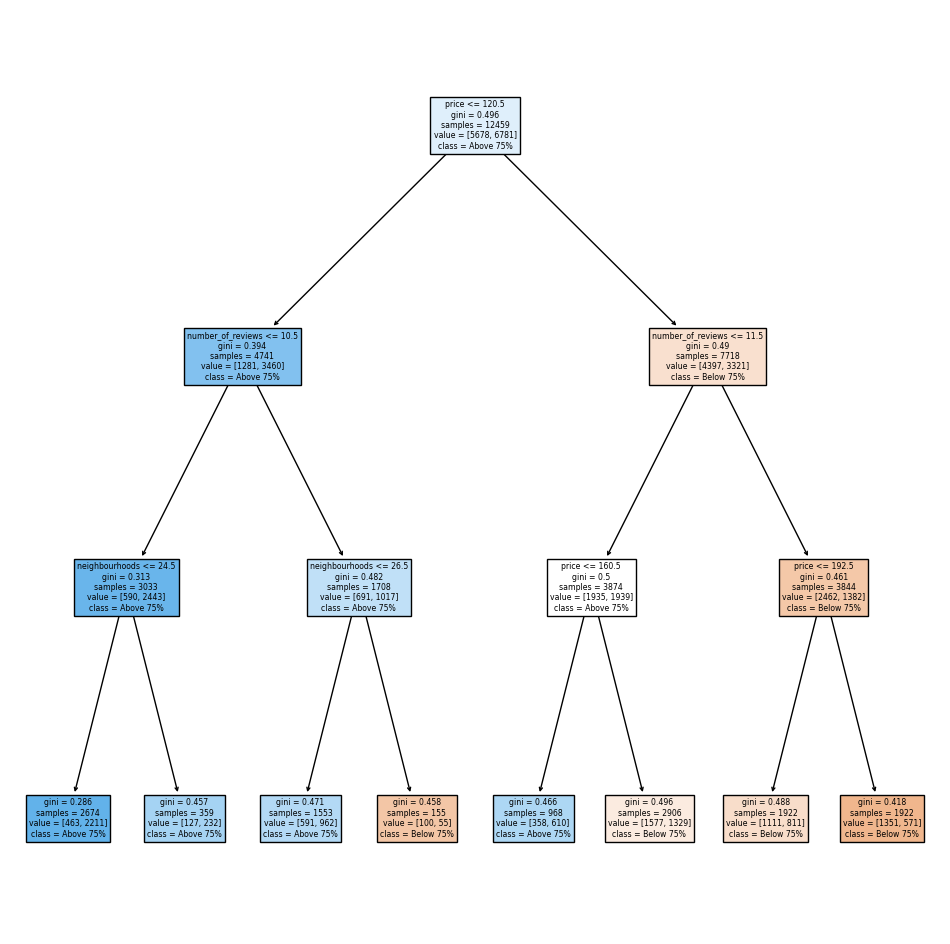

In [34]:
# Visualizing the decision tree

plt.figure(figsize=(12, 12))
plt.title('Decision Tree')
plot_tree(model, filled=True, class_names=['Below 75%', 'Above 75%'], feature_names=feature_names)
plt.show()

In [35]:
# Creating the test variable as P

P = model.predict(X_test)

In [36]:
# Checking for the accuracy score

acc = metrics.accuracy_score(Y_test, P)
print(f'Accuracy score for the decision tree = {acc}')

Accuracy score for the decision tree = 0.6418244149649724


The accuracy score represents the percentage of correct predictions for the dataset using the Decision Tree. In this case, around 64%.

In [37]:
# Checking the confusion matrix

cm = metrics.confusion_matrix(Y_test, P)
print(f'Confusion matrix for the decision tree = \n{cm}')

Confusion matrix for the decision tree = 
[[2200  827]
 [1576 2106]]


The model predicts the "Above 75%" class better, according to the confusion matrix, as seen on the main diagonal.

In [38]:
# Checking the classification report

class_report = metrics.classification_report(Y_test, P, target_names=['Below 75%', 'Above 75%'])
print(f'Classification report for the decision tree = \n{class_report}')

Classification report for the decision tree = 
              precision    recall  f1-score   support

   Below 75%       0.58      0.73      0.65      3027
   Above 75%       0.72      0.57      0.64      3682

    accuracy                           0.64      6709
   macro avg       0.65      0.65      0.64      6709
weighted avg       0.66      0.64      0.64      6709



Better predictions for the "Above 75%" can also be confirmed by the metrics shown above.

## Logistic Regression

Now it's time to check if a Logistic Regression would be a good fit to study this dataset.

In [39]:
#print([type(arr) for arr in X_test])

In [40]:
# Getting data from "filtered_data" and creating an array, tranforming categorical variables into
# numerical ones and strings into floats for the Logistic Regression

FILE_NAME = '/content/filtered_data.csv'
with open(FILE_NAME, mode='r', encoding='utf-8') as csvfile:
    reader = csv.DictReader(csvfile)
    lines, skeys = [], ['price', 'minimum_nights', 'number_of_reviews', 'neighbourhood', 'room_type', 'availability_365']
    for row in reader:
        if row:
            lines.append([row[chave] for chave in skeys])
    #print(lines) # Printing the line before scaling categorical variables

    # Scaling neighbourhood field
    for line in lines:
      for k, v in dict_neigh.items():
        if line[3] == k:
          line[3] = v

      # Scaling room type field
      for k, v in dict_roomtype.items():
        if line[4] == k:
          line[4] = v

      # Transforming strings in numbers
      for i in line:
        i = int(i)


    #print(lines) # Printing the line after scaling categorical variables

    num_data = np.array(lines).astype(float)

    print(f'There are {len(num_data)} elements') # Checking for elements
    print(f' Shape of data (rows, columns) = {num_data.shape}') # Checking for rows and columns

There are 19168 elements
 Shape of data (rows, columns) = (19168, 6)


In [41]:
# Defining X as the array containing all values except for the availability_365
# and Y as the binary target array created above

new_data = [line[:-1] for line in num_data]
X = np.array(new_data)
Y = np.array(target)

print(X.shape)
print(Y.shape)

(19168, 5)
(19168,)


In [42]:
# Defining train and test split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)

In [43]:
# Choosing the model

model = LogisticRegression(max_iter=1000)

In [44]:
# Fitting the data into the Logistic Regression Model

model.fit(X_train, Y_train)

LogisticRegression(max_iter=1000)

In [45]:
# Calculating probabilities on the test set

y_probs = model.predict_proba(X_test)[:, 1]

In [46]:
# Obtaining binary prediction where 1 == Above 75% occupancy rate and 0 == Below 75%

y_pred = np.where(y_probs > 0.5, 1, 0)

In [47]:
# Checking the confusion matrix

cm = metrics.confusion_matrix(Y_test, y_pred)
print(f'Confusion matrix for the decision tree = \n{cm}')

Confusion matrix for the decision tree = 
[[1045 1132]
 [ 603 2012]]


Comentário sobre a matriz de confusão

In [48]:
# Calculating ROC Curve

fpr, tpr, _ = metrics.roc_curve(Y_test, y_probs)

In [49]:
# Calculating AUC ROC

auc_roc = metrics.roc_auc_score(Y_test, y_probs)
print('AUC-ROC:', auc_roc)

AUC-ROC: 0.7030062244690933


The AUC-ROC metric = 0.70 shows that the model's performance can be considered acceptable, but there is room for improvements.

In [50]:
# Accuracy

acc = metrics.accuracy_score(Y_test, y_pred)
print(acc)

0.6379382303839732


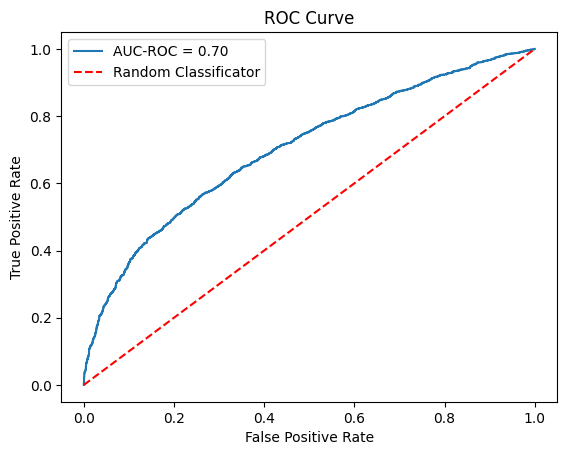

In [51]:
# Plotting ROC Curve

plt.plot(fpr, tpr, label=f'AUC-ROC = {auc_roc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Classificator')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

### Conclusion

In conclusion, the Logistic Regression Model can be used to predict if a listing would have an occupancy rate above or below 75% through the next year.

The probability could be even higher with a bigger and more representative dataset.

## PCA

In [52]:
# Normalizing the data (using the same X and Y variables created for Logistic Regression)

data = StandardScaler().fit_transform(X)
#print(X[0], data[0])

Normalizing the data is necessary because the PCA technique is scale sensitive, and it turns all feature's means = 0 and variance = 1.

In [53]:
# Applying PCA

pca = PCA()
components = pca.fit_transform(data)
print(components.shape)
#print(components)

(19168, 5)


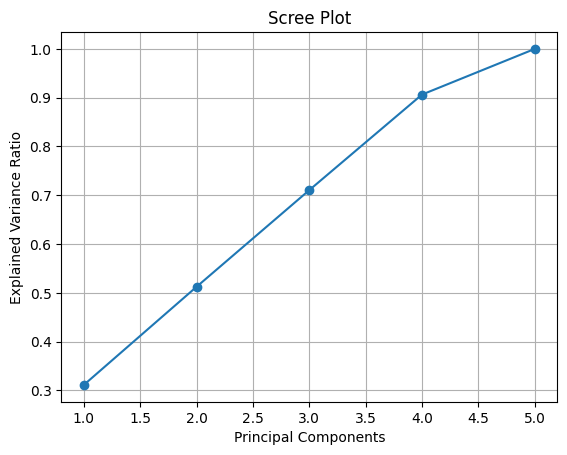

In [54]:
# Plotting scree plot

plt.plot(range(1, 6), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid('True')
plt.show()

90% of the explained variance ration is achieved with 4 components (out of 5), so using 4 would be enough to reduce the dataset size while preserving the most information.

In [55]:
# For academic reasons, will reduce the dataset to 2 components

pca = PCA(n_components=2)
components = pca.fit_transform(data)

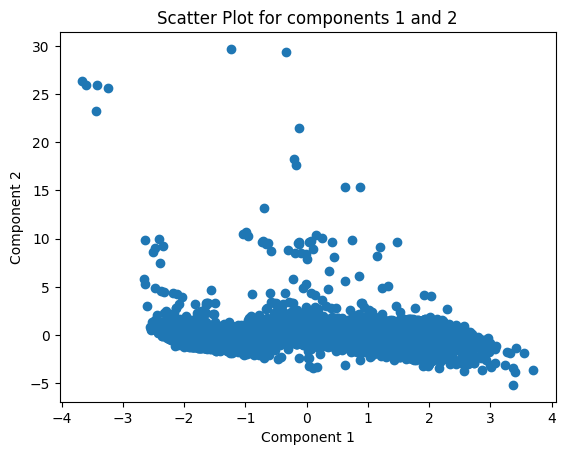

In [56]:
# Scatter plot for components

eixox, eixoy = [], []
for row in components:
  eixox.append(row[0])
  eixoy.append(row[-1])

plt.figure()
plt.scatter(eixox, eixoy)
plt.title('Scatter Plot for components 1 and 2')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

## Conclusão

1. First, it is essential to have a clean dataset in order to work with machine learning algorithms. As for this project the goal was to analyze the dataset based on the "price" field, it was cleaned accordingly.

2. Using only 1 variable and the price variable does not provide enough information to use the Linear Regression model to predict a listing's price, as proved by the R² scores and the scatter plots generated for each crossing.

3. The decision tree can be used to predict if a listing will be occupied more or less than 75% of the next year, based on the features it presents.

4. The Logistic Regression Model can also be used to predict if a listing will have an occupancy rate above or below 75% through the next year, as its AUC-ROC metric is around 70%.

5. Finally, the PCA algorithm was tested for the dataset and showed that from 5 components, 4 would explain approximately 90% of the dataset. As it is a small dataset (considering number of components), reducing it would not have a big impact in regards to performance and/or usability of the dataset in other machine learning algorithms.
